In [25]:
import time
from collections import deque, namedtuple

import base64
import imageio
import gymnasium as gym
import numpy as np
# import PIL.Image
import tensorflow as tf
import IPython

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import random
import PIL.Image
from tensorflow.keras.losses import MSE
from IPython.display import Video
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd


In [3]:
SEED = 0
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 7  # perform a learning update every C time steps
MINIBATCH_SIZE = 64  # Mini-batch size.
TAU = 1e-3  # Soft update parameter.
E_DECAY = 0.995  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.

In [4]:
SEED = 0
random.seed(SEED)

In [44]:
# 0: Push cart to the left
# 1: Push cart to the right
# tf.random.set_seed(SEED)

In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [7]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (4,)
Number of actions: 2


In [8]:
current_state = env.reset()
# current_state = np.reshape(current_state[0], (1, state_size[0]))
print(current_state)

(array([ 0.03591099,  0.01730918, -0.00259908, -0.04637566], dtype=float32), {})


In [9]:
# next_state = Cart Pos, Cart Velo, Pole Angle, Pole Velo
# reward = +1 for every step taken
action = 0
next_state, reward, done, _, _ = env.step(action)
current_state = next_state

Formula
$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$


We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$


$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$


$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$


In [10]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=num_actions, activation='linear')
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=num_actions, activation='linear')
])
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=ALPHA)

In [11]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

In [12]:
def compute_loss(experiences : namedtuple, gamma : float, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """


    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - float(done_vals)))

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    # Compute the loss
    loss = MSE(y_targets, q_values) 
    
    return loss

In [13]:
def update_target_network(q_network, target_q_network):
    """
    The weights of the target_q_network are updated using the soft update rule:    
                    w_target = (TAU * w) + (1 - TAU) * w_target
    
    TAU is the soft update
    Args:
        q_network (tf.keras.Sequential): 
        target_q_network (tf.keras.Sequential):
    """

    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [14]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [15]:
def get_action(q_values, epsilon=0.0) -> int:

    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(2))

In [16]:
def check_update_conditions(t, num_steps_upd, memory_buffer) -> bool:
    """
    Determines if the conditions are met to perform a learning update.

    Checks if the current time step t is a multiple of num_steps_upd and if the
    memory_buffer has enough experience tuples to fill a mini-batch 

    """

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [17]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

In [28]:
start = time.time()

num_episodes = 6000
max_num_steps = 1000

total_points_history = []

num_p_avg = 100 # Number of total points 
epsilon = 0.5 # Initial epsilon value

# Initialize memory buffer
memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    # state = env.reset()
    state, _ = env.reset()
    total_points = 0
    for t in range(max_num_steps):
        state_qn = np.expand_dims(state, axis=0) # right shape for q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # get next state and reward from action
        next_state, reward, done, _, _ = env.step(action)
        
        # add experience to memory buffer
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        if check_update_conditions(i, NUM_STEPS_FOR_UPDATE, memory_buffer):
            # Sample a mini-batch of experiences from the memory buffer
            minibatch_experiences = get_experiences(memory_buffer)
            # Perform a learning update
            agent_learn(minibatch_experiences, GAMMA)
            
        state = next_state.copy()
        total_points += reward
        if done:
            break
        
    total_points_history.append(total_points)
    
    avg_latest_points = np.mean(total_points_history[-num_p_avg:])
    
    #update epsilon
    epsilon = max(E_MIN, E_DECAY * epsilon)
    
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_avg} episodes: {avg_latest_points:.2f}", end="")

    if (i+1) % num_p_avg == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_avg} episodes: {avg_latest_points:.2f}")
        
    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if avg_latest_points >= 400.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('Cart_pole_model.h5')
        break
    
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: 160.79
Episode 200 | Total point average of the last 100 episodes: 204.87
Episode 300 | Total point average of the last 100 episodes: 236.53
Episode 400 | Total point average of the last 100 episodes: 309.35
Episode 500 | Total point average of the last 100 episodes: 342.89
Episode 600 | Total point average of the last 100 episodes: 306.94
Episode 700 | Total point average of the last 100 episodes: 299.79
Episode 744 | Total point average of the last 100 episodes: 401.35

Environment solved in 744 episodes!

Total Runtime: 93.94 s (1.57 min)


In [45]:

def create_video(filename, env, q_network, fps=30):
    start = time.time()
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state, _ = env.reset()
        frame = env.render()
        video.append_data(frame)
        while not done:
            if time.time() - start > 20:
                break
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

    env.close()


In [47]:
def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)

In [48]:
filename = "./cart_pole.mp4"
# create_video(filename, env, q_network)
embed_mp4(filename)

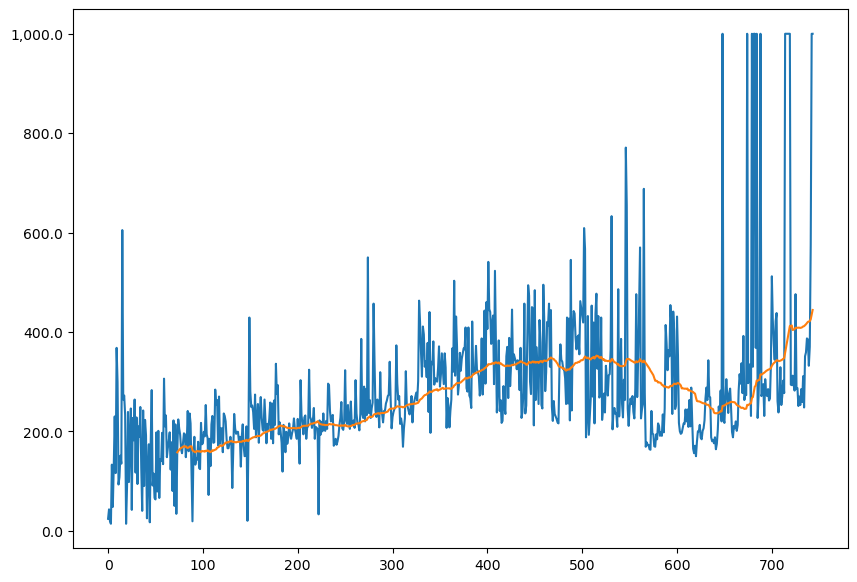

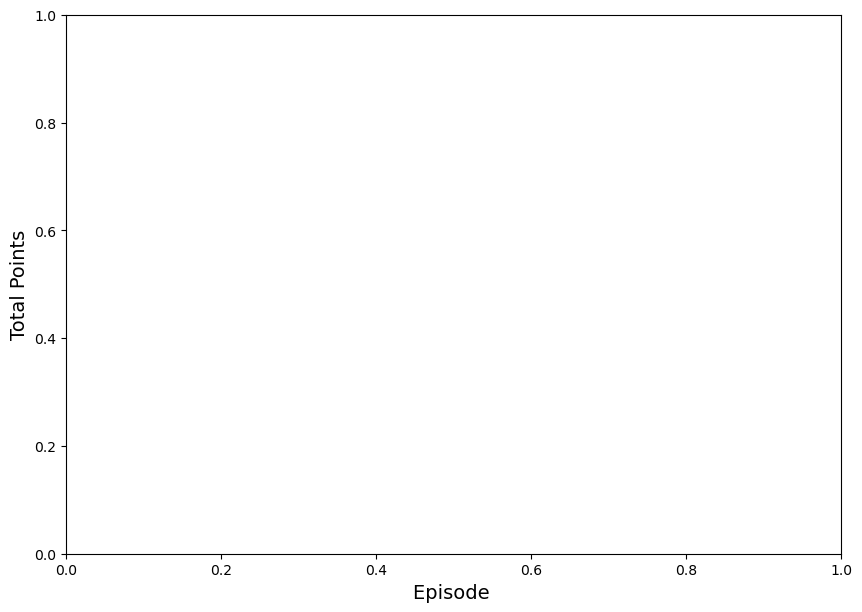

In [50]:
upper_limit = len(total_points_history)
points = total_points_history
episode_num = [x for x in range(0, upper_limit)]
window_size = (upper_limit * 10) // 100

# Use Pandas to calculate the rolling mean (moving average).
rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

# Create a single figure
plt.figure(figsize=(10, 7), facecolor="white")

# Plotting the data
plt.plot(episode_num, points, label="Total Points")
plt.plot(episode_num, rolling_mean, label="Moving Average")

# Setting up the axes, labels, and formatting
ax = plt.gca()
text_color = "black"
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Points", fontsize=14)
yNumFmt = mticker.StrMethodFormatter("{x:,}")
ax.yaxis.set_major_formatter(yNumFmt)
ax.tick_params(axis="x", colors=text_color)
ax.tick_params(axis="y", colors=text_color)

# Show the plot
plt.show()